<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Amirreza Bagheri Delouee
### Student Number : 98109804
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [36]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [21]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.1307, std=0.3081)
]) # Write your code here

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [22]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [23]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
train_loader = DataLoader(train_data, batch_size=16, shuffle=True) # Write your code here
val_loader = DataLoader(valid_data, batch_size=16, shuffle=False) # Write your code here

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [26]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self, in_channels):
        super(ResidualClassifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 10)
            #nn.ReLU()
        )
        pass # Write your code here

    def forward(self, x):
        x = self.conv1(x)
        res1 = x
        x = self.conv2(x)
        x = res1+x
        x = self.conv3(x)
        res2 = x
        x = self.conv4(x)
        x = res2+x
        x = self.conv5(x)
        y = F.softmax(x)
        return y
        pass # Write your code here

# Train Model (30 Points)

In [27]:
def update_confusion_matrix(conf_matrix, preds, reals):
    for i in range(len(reals)):
        conf_matrix[reals[i]][preds[i]] += 1
    return conf_matrix


def f1_score(confusion_matrix):
    TP = np.diag(confusion_matrix)
    FN = np.sum(confusion_matrix, axis=1) - TP
    FP = np.sum(confusion_matrix, axis=0) - TP
    f1_score = np.mean(TP/(TP + 1/2 * (FP+FN)))
    
    return f1_score

In [28]:
def test(model, loader, f_loss, device, num_classes):
    with torch.no_grad():
        model.eval()
        N = 0
        total_loss, correct = 0.0, 0.0
        confusion_matrix = np.zeros((num_classes, num_classes))
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.to(torch.float32)

            outputs = model(inputs)

            N += inputs.shape[0]

            total_loss += inputs.shape[0] * f_loss(outputs, targets).item()

            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()

            update_confusion_matrix(conf_matrix=confusion_matrix, 
                                    preds=predicted_targets, 
                                    reals=targets)
            f1 = f1_score(confusion_matrix)
        return total_loss/N, correct/N, f1, confusion_matrix

In [29]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier(1).to(device)
criterion = nn.CrossEntropyLoss() # Write your code here
optimizer = torch.optim.Adam(model.parameters()) # Write your code here

In [30]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
total_step = len(train_loader)
num_epochs = 20

val_losses = []
val_accs = []
val_f1s = []
train_losses = []
train_accs = []
train_f1s = []

best_model = None
best_f1 = 0

num_classes = 10

for epoch in range(num_epochs):
    print("Epoch {}".format(epoch))
    model.train()
    for images, labels in train_loader: 
        # Write your code here
        images, labels = images.to(device), labels.to(device)

        images = images.to(torch.float32)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        # Write your code here
        val_loss, val_acc, val_f1, _ = test(model, val_loader, criterion, device, num_classes)
        train_loss, train_acc, train_f1, _ = test(model, train_loader, criterion, device, num_classes)
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_f1s.append(train_f1)

        if (val_f1 > best_f1):
            best_model = model
            best_f1 = val_f1
    
        print(" Training : Loss : {:.4f}, Acc : {:.4f}, F1 : {:.4f}".format(train_loss, train_acc, train_f1))
        print(" Validation : Loss : {:.4f}, Acc : {:.4f}, F1: {:.4f}".format(val_loss, val_acc, val_f1))

Epoch 0


<ipython-input-26-760aa5e5996e>:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(x)
<ipython-input-27-57c8fb5576bb>:11: RuntimeWarning: invalid value encountered in true_divide
  f1_score = np.mean(TP/(TP + 1/2 * (FP+FN)))


 Training : Loss : 1.5243, Acc : 0.9371, F1 : 0.9373
 Validation : Loss : 1.5253, Acc : 0.9365, F1: 0.9367
Epoch 1
 Training : Loss : 1.4995, Acc : 0.9618, F1 : 0.9614
 Validation : Loss : 1.4993, Acc : 0.9627, F1: 0.9624
Epoch 2
 Training : Loss : 1.4877, Acc : 0.9735, F1 : 0.9733
 Validation : Loss : 1.4873, Acc : 0.9741, F1: 0.9739
Epoch 3
 Training : Loss : 1.4955, Acc : 0.9658, F1 : 0.9659
 Validation : Loss : 1.4970, Acc : 0.9639, F1: 0.9638
Epoch 4
 Training : Loss : 1.4913, Acc : 0.9697, F1 : 0.9694
 Validation : Loss : 1.4931, Acc : 0.9679, F1: 0.9677
Epoch 5
 Training : Loss : 1.4800, Acc : 0.9810, F1 : 0.9810
 Validation : Loss : 1.4805, Acc : 0.9807, F1: 0.9806
Epoch 6
 Training : Loss : 1.4917, Acc : 0.9694, F1 : 0.9692
 Validation : Loss : 1.4898, Acc : 0.9715, F1: 0.9714
Epoch 7
 Training : Loss : 1.4827, Acc : 0.9784, F1 : 0.9782
 Validation : Loss : 1.4843, Acc : 0.9765, F1: 0.9763
Epoch 8
 Training : Loss : 1.4846, Acc : 0.9766, F1 : 0.9764
 Validation : Loss : 1.4859

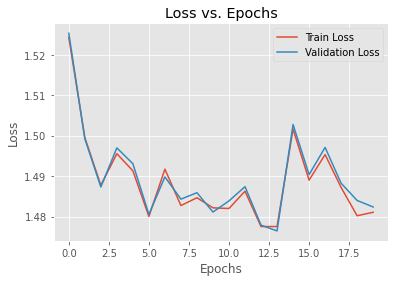

In [31]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

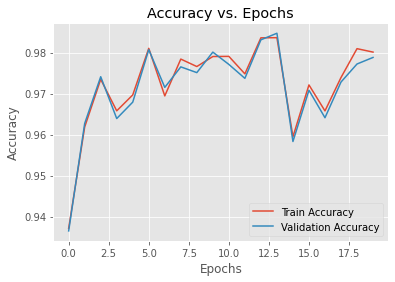

In [32]:
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

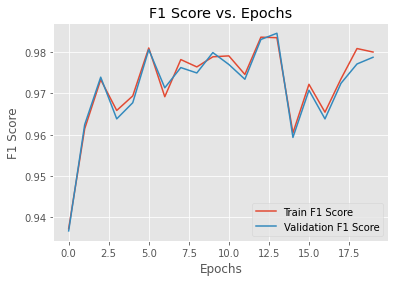

In [33]:
plt.plot(train_f1s, label='Train F1 Score')
plt.plot(val_f1s, label='Validation F1 Score')
plt.title("F1 Score vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

# Test Model (20 Points)

In [34]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))

with torch.no_grad():
    # Write your code here
    test_loss, test_acc, test_f1, confusion_matrix = test(best_model, test_loader, criterion, device, num_classes)
    print(" Test : Loss : {:.4f}, Acc : {:.4f}, F1: {:.4f}".format(test_loss, test_acc, test_f1))

10000


<ipython-input-26-760aa5e5996e>:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(x)


 Test : Loss : 1.4794, Acc : 0.9817, F1: 0.9817


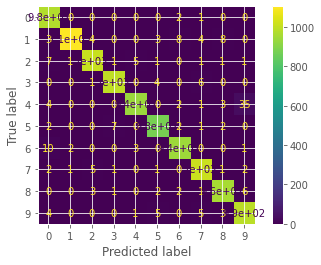

In [35]:
conf_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, )
conf_disp.plot()
plt.show()